<h1><center>Programming Exercise 4:<br>Neural Networks Learning</center></h1>

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.io import loadmat 
from scipy.misc import toimage
import random

mpl.rcParams['figure.figsize'] = (10,6)

# 1. Neural Networks (NN)
- In the previous exercise we implemented feedforward propagation for neural networks and used it to predict handwritten digits with the weights provided. Here, we will implement the backpropagation algorithm to learn the parameters for the NN

## 1.1 Visualizing the data
- Dataset of digit images is the same as last week's with the label "10" for the digit "0"

In [2]:
data1 = loadmat('ex4data1.mat')
# X is the design matrix of 5000 samples, 400 features for each
# Each sample actually comes from a 20 pixel by 20 pixel image (grayscale) thus comprises a 400-dimensional vector
# y is the output vector with class labels from 1-10; note that the 0 class has been mapped to the number 10 (this is to address an Octave/Matlab indexing issue)
X, y  = data1['X'], data1['y'].flatten() # flatten the second to make it a row vector (as our notational formalism expects)!!
X = np.c_[np.ones(np.shape(X)[0]),X] # add bias terms
np.place(y,y==10,0) # replace labeled 10's with 0's for all sample

- Recall from ex3 that to we need to flip them upsidedown and rotate them by 270 degrees to get the display right

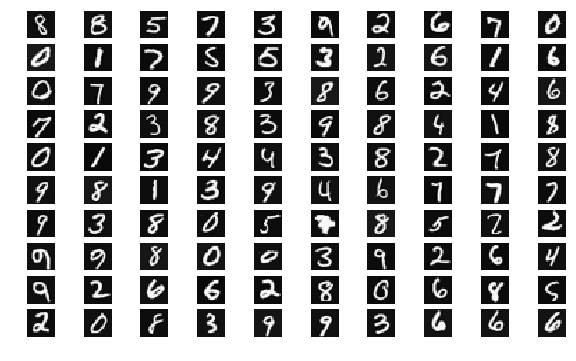

In [3]:
# Select 100 random indices and plot the samples
rand_ind = random.sample(range(0,X.shape[0]),100) # 100 random samples from given population (sequence)

# Save 100 random samples (reshaped into 20 by 20) in array
rand_sample_arr = np.array([np.flipud(np.reshape(X[ii_ind,1:],(20,20))) for ii_ind in rand_ind]) # ignoring the bias term

# Plot all images as subplots of one figure
plt.figure()
for ii_idx,ii_sample in enumerate(rand_sample_arr):
    ii_image = toimage(ii_sample)
    ii_image = ii_image.rotate(270)
    plt.subplot(10,10,ii_idx+1)
    plt.imshow(ii_image,cmap='Greys_r')
    plt.axis('off')
plt.show()

## 1.2 Model Representation
- As in ex3, we have a NN with 3 layers (input, hidden, and output) where the hidden layer has 25 activation units and the output has 10 units
- The network parameters $\Theta^{(1)}$ and $\Theta^{(2)}$ have already been trained and provided:

In [4]:
data2 = loadmat('ex4weights.mat')

theta1, theta2 = data2['Theta1'], data2['Theta2'] 

# Check shapes
print('theta1 shape is: {}'.format(np.shape(theta1)))
print('theta2 shape is: {}'.format(np.shape(theta2)))

theta1 shape is: (25, 401)
theta2 shape is: (10, 26)


## 1.3 Feedforward and Cost Function
- The NN cost function (cross-entropy loss) is:

$$
J(\Theta) = \frac{1}{m}\sum_{i=1}^m\sum_{k=1}^K \left[-y_k^{(i)}\log((h_\Theta(x^{(i)}))_k)-(1-y_k^{(i)})\log(1-(h_\Theta(x^{(i)}))_k)\right] + \frac{\lambda}{m}\sum_{l=1}^{L-1}\sum_{i=1}^{s_l}\sum_{j=1}^{s_{l+1}}\left(\Theta_{ji}^{(l)}\right)^2
$$

- Here we implement forward-prop and cost function w/o regularization
- Andrew NG recommended doing everything with for loops, however we already vectorized the forward prop procedure in ex3.ipynb (see Section 2 notes and `predict` function). We'll edit the `predict` function of ex3 here to give us back the (probability matrix) outputs rather than the label prediction

In [9]:
def sigmoid(z):
    '''
    Computes the sigmoid function given input z
    
    Parameters
    ----------
    z: array
    
    Returns
    -------
    value of sigmoid at the given vector z
    '''
    return 1/(1+np.exp(-z))

def forwardProp(theta1,theta2,X):
    '''
    Performs forward propagation to give output of a three-layer Neural Network with p
    (not counting bias) activation units in second layer (hidden) and K units in output 
    layer given the weight matrices of propagation Theta1 and Theta2 and design matrix 
    of samples X
    
    Parameters
    ----------
    theta1: p by (n+1) matrix of optimized thetas for transition between input layer and hidden layer
    theta2: K by (p+1) matrix of optimized thetas for transition between hidden layer and output layer
    X: m by (n+1) design matrix (includes bias units)
    
    Returns
    -------
    prob_matrix: K by m matrix of probabilities for m samples to belong to K classes
    a2_matrix: (p+1) by m matrix of activation at layer 2 (needed for backProp function)
    '''    
    
    # See ex3.ipynb Section 2 notes for explanation of procedures
    m = np.shape(X)[0] # sample size
    a2_matrix = sigmoid(theta1 @ X.T) # initial layer 2 activation units 
    bias_row = np.ones((1,m)) # bias term for second layer activation
    a2_matrix = np.vstack((bias_row,a2_matrix)) # insert bias term
    prob_matrix = sigmoid(theta2 @ a2_matrix) # Since this is the output, no bias term needs to be added for further computation
                                              # This is the matrix of probabilities, each colum for a sample
                                              # and a row for each class 0-9
    prob_matrix = np.roll(prob_matrix,1,axis=0) # shift entries in each column by 1, i.e colum [1,2,3] becomes [3,2,1]
                                                # see note in ex3.ipynb section 2 under definition of predict()
                                                # note that this line in the code is particular to this problem and should be omitted otherwise as long as labels are defined correctly
    return prob_matrix, a2_matrix

- In Logistic Regression the cost function

$$
J(\theta)=\frac{-1}{m}\sum_{i=1}^m\left[y^{(i)}\log h_\theta(x^{(i)})+(1-y^{(i)})\log(1-h_\theta(x^{(i)}))\right]+\frac{\lambda}{2m}\sum_{j=1}^n\theta_j^2
$$

has the vectorized form:

$$
J(\theta)=\frac{-1}{m}\left[Y^T\cdot\log g(X\cdot \theta)+(1-Y)^T\cdot\log(1-g(X\cdot \theta))\right]+\frac{\lambda}{2m}\theta^T[1:]\cdot\theta[1:]
$$

for $X$ of shape $m\times(n+1)$, $\theta$ of shape $(n+1)\times 1$, and $Y$ of shape $m\times1$. This makes $g(X\cdot \theta)$ of shape $m\times1$ which can then be dotted by $Y^T$ to give us the scalar value of $J(\theta)$. Note that what we do here is multiply the labeled value $y^{(i)}$ times the value the machine predicts $h_\theta(x^{(i)})$ for every sample and then we sum all these to compute the cost $J$
- In NN, the hypothesis $h_\Theta(X)$ is a matrix of shape $K\times m$ for $K$ classes and $m$ samples with a column per sample of form $a^{(3)}_{:,i}=[a^{(3)}_{i,1},a^{(3)}_{i,2},...,a^{(3)}_{i,K}]$. Also, the $y$ values are no longer scalars but vectors $y=[y_{i,1},y_{i,2},...,y_{i,K}]$ for sample $i$ where only one such value in the vector is 1 and the rest 0. Thus for all the samples have a matrix $Y$ of shape $K\times m$. For every sample, we have to sum the contributions to the cost for all classes $K$ (look at the form of the cost for NN above). Thus we are interested in taking the Hadamard (entrywise) product:

$$
Y\circ h_\Theta(X)
=
\begin{bmatrix}
a^{(3)}_{1,1}\cdot y_{1,1} & \dots & a^{(3)}_{m,1}\cdot y_{m,1} \\
\vdots & \ddots & \vdots \\
a^{(3)}_{1,K}\cdot y_{1,K} & \dots & a^{(3)}_{m,K}\cdot y_{m,K}
\end{bmatrix}
$$

of shape $K\times m$ where a column corresponds to a sample. Since, per sample (column), only one value of y will be 1 and the rest 0, this matrix collapses to a vector of shape $1\times m$. The final step is then to sum the entries of this vector to get the contribution to the cost $J$ from all samples
- For the regularization term, first note that the matrix of weights from layer $l$ with $s_l$ activation units to $l+1$ with $s_{l+1}$ activation units is:

$$
\Theta^{(l)}
=
\begin{bmatrix}
\Theta^{(l)}_{11} & \dots & \Theta^{(l)}_{1s_l} \\
\vdots & \ddots & \vdots \\
\Theta^{(l)}_{s_{l+1}1} & \dots & \Theta^{(l)}_{s_{l+1}s_l}
\end{bmatrix}.
$$

After expanding the regularization term in $J$ we can see that it is the sum of squares of every element of such a matrix's entries, and we do this for every $l$ there is. Note that since we don't regularize the bias term then for every matrix at layer $l$ we omit the first column $\Theta^{(l)}_{:,1}$ 
- If we define the vector $\mathbf{e}$ as a vector with 1's for all entries and of approrpiate size (into whatever matrix its multiplying into) then we can write the cost function for NN as:

$$
J(\Theta) = \frac{-1}{m}\mathbf{e}^T\cdot [Y\circ\log h_\Theta(X)]+(1-Y)\circ \log(1-h_\Theta(X))]\cdot\mathbf{e}+\frac{\lambda}{2m}\sum_{l=1}^{L-1}\mathbf{e}^T\cdot[\Theta^{(l)}\circ\Theta^{(l)}]\cdot\mathbf{e}
$$

where $h_\Theta(X)$ is the output of forward-prop. This encapsulates all the notes discussed here

- First let's get our $Y$ matrix:

In [6]:
y_matrix = np.zeros((10,np.shape(X)[0])) # initialize with zeros; of shape K=10 by m 
for ii_idy,ii_y in enumerate(y):
    y_matrix[ii_y,ii_idy] = 1 # set = 1 at the class label, i.e the index

- Now define the cost function:

In [7]:
def costFunction(theta_flat,input_layer_size,hidden_layer_size,num_labels,X,Y,reg_param=0):
    '''    
    Computes the cost function for a NN with architecture: 3 hidden layers, hidden_layer_size activation units
    in hidden layer and num_labels output units in final layer given a design matrix X of shape m by input_layer_size,
    y matrix Y of shape K=num_labels by m with labels for the outputs.
    Returns the scalar J
    
    Parameters
    ----------
    theta_flat: array made up of values for transition matrices theta1 and theta2 (when flattened and appended back to back)
    input_layer_size: # of input features i.e n+1
    hidden_layer_size: # of activation units in the hidden layer 
    num_labels: # of classes for classification, K
    X: m by input_layer_size design matrix
    Y: K=num_labels by m output matrix
    reg_param (optional): scalar, regularization parameter; default is 0
    
    Returns
    -------
    costJ: scalar, value of the cost function
    '''
    
    m = np.shape(X)[0] # sample size
    
    # Recover thetas from flattened array:
    theta1 = np.reshape(theta_flat[:hidden_layer_size*input_layer_size],(hidden_layer_size,input_layer_size)) 
    theta2 = np.reshape(theta_flat[hidden_layer_size*input_layer_size:hidden_layer_size*input_layer_size+(hidden_layer_size+1)*num_labels],(num_labels,hidden_layer_size+1)) 
    
    hypothesis,_ = forwardProp(theta1,theta2,X)
    costJ_vector = -1/m*(Y*np.log(hypothesis)+(1-Y)*np.log(1-hypothesis)) # * is the Hadamard product
    reg_term = 0
    for ii_theta in [theta1,theta2]: # 3 layers so two transition matrices, this is the sum over l=1,...,L-1
        reg_term += np.sum(ii_theta[:,1:]*ii_theta[:,1:]) # ignore the bias terms
    costJ = np.sum(costJ_vector) + reg_param/(2*m)*reg_term

    return costJ

In [69]:
theta_flat = np.r_[np.ndarray.flatten(theta1),np.ndarray.flatten(theta2)]
input_layer_size = 401
hidden_layer_size = 25 
num_labels = 10
costFunction(theta_flat,input_layer_size,hidden_layer_size,num_labels,X,y_matrix,reg_param=0)

0.28762916516131887

boo yah! got it

## 1.4 Regularized Cost Function
- The full version of the cost function including regularization is implemented above so let's test it here:

In [12]:
costFunction(theta_flat,input_layer_size,hidden_layer_size,num_labels,X,y_matrix,reg_param=1)

0.38376985909092359

got it again!

# 2. Backpropagation
- Implement the backpropagation algorithm to compute the gradient for the NN cost function. Once we have computed the gradient, we will train the NN by minimizing the cost function $J(\Theta)$ using an advanced optimizer 

## 2.1 Sigmoid Gradient
- Implement the sigmoid gradient function:

$$
g'(z) = \frac{d}{dz}g(z)=g(z)(1-g(z))
$$

In [13]:
def sigmoidGrad(z):
    '''
    Computes the gradient of the sigmoid function given input z
    
    Parameters
    ----------
    z: array
    
    Returns
    -------
    value of derivative of sigmoid at the given z
    '''
    return sigmoid(z)*(1-sigmoid(z)) # Hadamard product interpretation for matrices is valid here 

In [14]:
# Test it
print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1] is:\n{}'.format(sigmoidGrad(np.array([-1,-0.5,0,0.5,1]))))

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1] is:
[ 0.19661193  0.23500371  0.25        0.23500371  0.19661193]


## 2.2 Random Initialization
- Select initial values for $\Theta^{(l)}$ in the range $[-\epsilon_l,\epsilon_l]$
- An effective strategy for choosing $\epsilon_l$ is to pick

$$
\epsilon_l=\frac{\sqrt6}{\sqrt{s_l+s_{l+1}}}
$$

where $s_l$ and $s_{l+1}$ are the number of units in the layers adjacent to $\Theta^{(l)}$. For our NN this is to $\epsilon_1=0.1186$ and $\epsilon_2=0.4082$. The assignment tells us to use $\epsilon=0.12$ but I'll use the formula to compute custom range bounds for each layer

In [15]:
def randInitializeWeights(s_l, s_lp1):
    '''
    Returns the matrix Theta^(l) for transition between layer l and l+1 with values 
    initialized in the half-open interval [-epsilon,epsilon). If layer l has s_l neurons
    and layer l+1 has s_lp1 neurons then epsilon is calculated as sqrt(6)/sqrt(s_l+s_lp1)
    
    Parameters
    ----------
    s_l: # of units in layer l
    s_lp1: # of units in layer l+1
    
    Returns
    -------
    init_theta: s_lp1 by s_l shape array, initialized Theta^(l) 
    '''
    epsilon = np.sqrt(6)/np.sqrt(s_l+s_lp1)
    init_theta = np.random.uniform(low=-epsilon,high=epsilon,size=(s_lp1,s_l))
    return init_theta

In [16]:
theta1_init = randInitializeWeights(401,25)
theta2_init = randInitializeWeights(26,10)

## 2.3 Backpropagation
- Let's vectorize this step as well for a set of $m$ samples
- The first step is to compute the error at the output $\delta^{(3)}=A^{(3)}-Y$. Here $A^{(3)}$ is the output of the forward propagation, that is the output at layer 3, of shape $K\times m$ (with $K=10$ in our case). The $i^\text{th}$ column corresponds to the  $i^\text{th}$ sample and is of form $a^{(3)}_{:,i}=[a^{(3)}_{i,1},a^{(3)}_{i,2},...,a^{(3)}_{i,K}]$, i.e the probabilities for sample $i$ to be in class $k$ of total $K$ classes
- The error at a lower layer $l$ is given by:

$$
\delta^{(l)} = (\Theta^{(l)}[:,1:])^T\cdot\delta^{(l+1)}\circ g'(z^{(l)})
$$

with $z^{(l)}=\Theta^{(l-1)}\cdot A^{(l-1)}$. Note that we skip the first column in $\Theta^{(l)}$ since this corresponds to the bias terms
- Since we have 3 layers we have 2 errors. The last error is given above while the second is:

$$
\delta^{(2)} = (\Theta^{(2)}[:,1:])^T\cdot\delta^{(3)}\circ g'(z^{(2)})
$$

with $z^{(2)}=\Theta^{(1)}\cdot A^{(1)}$. The shape of $A^{(1)}$ is $(n+1)\times m$ for $n=400$ features and $\Theta^{(1)}$ is of shape $25\times 401$ so that both $z^{(2)}$ and $g'(z^{(2)})$ are of dimension $25\times m$. The shape of $\delta^{3}$ is $10\times m$ as noted above and $(\Theta^{(2)}[:,1:])^T$ is of shape $25\times10$ so their dot product is of shape $25\times m$. Thus we can take the Hadamard product of these two terms of the same shape to compute the error $\delta^{(2)}$ of shape $25\times m$
- The next step is to compute the $\Delta^{(l)}$ terms:

$$
\Delta^{(l)} := \Delta^{(l)} + \delta^{(l+1)}\cdot (A^{(l)})^T
$$

where the initial $\Delta^{(l)}$ are initialized to zeros. Concretely we have to compute two of these terms:

$$
\begin{equation}
\begin{split}
\Delta^{(1)} & := \Delta^{(1)} + \delta^{(2)}\cdot (A^{(1)})^T \\
\Delta^{(2)} & := \Delta^{(2)} + \delta^{(3)}\cdot (A^{(2)})^T
\end{split}
\end{equation}
$$

since $(A^{(1)})^T$ is of shape $m\times401$ and $(A^{(2)})^T$ is of shape $m\times26$ we get $\Delta^{(1)}$ of shape $25\times401$ and $\Delta^{(2)}$ of shape $10\times26$
- Finally for layer $l$ we compute the gradient of the cost function as:

$$
\frac{\partial J}{\partial\Theta^{(l)}} \equiv D^{(l)} = \frac{1}{m}\Delta^{(l)}+\frac{\lambda}{m}\Theta^{(l)}
$$

which is the same shape as the $\Delta^{(l)}$'s. Note that regularization is not applied to the bias terms thus the rule becomes:

$$
\begin{equation}
\begin{split}
D^{(l)}[:,0] & = \frac{1}{m}\Delta^{(l)}[:,0] \\
D^{(l)}[:,1:] & = \frac{1}{m}\Delta^{(l)}[:,1:]+\frac{\lambda}{m}\Theta^{(l)}[:,1:]
\end{split}
\end{equation}
$$

- The end result are two matrices: $D^{(1)}$ of shape $25\times401$ and $D^{(2)}$ of shape $10\times26$

In [120]:
def backProp(theta_flat,input_layer_size,hidden_layer_size,num_labels,X,Y,reg_param=0):
    '''
    Performs back propagation to give gradients of cost function J for a three-layer NN 
    with p (not counting bias) activation units in second layer (hidden) and K units in output 
    layer given the weight matrices of propagation Theta1 and Theta2, design matrix 
    of samples X, and output matrix Y
    
    Parameters
    ----------
    theta_flat: array made up of values for transition matrices theta1 and theta2 (when flattened and appended back to back)
    input_layer_size: # of input features i.e n+1
    hidden_layer_size: # of activation units in the hidden layer 
    num_labels: # of classes for classification, K
    X: m by (n+1) design matrix (includes bias units)
    Y: K by m matrix of labeled values of training set
    
    Returns
    -------
    bigD1: p by (n+1) matrix, derivate of cost J w.r.t layer 1 transition matrix
    bigD2: K by (p+1) matrix, derivate of cost J w.r.t layer 2 transition matrix
    '''
    
    m = np.shape(X)[0] # sample size
    # Recover thetas from flattened array:
    theta1 = np.reshape(theta_flat[:hidden_layer_size*input_layer_size],(hidden_layer_size,input_layer_size)) 
    theta2 = np.reshape(theta_flat[hidden_layer_size*input_layer_size:hidden_layer_size*input_layer_size+(hidden_layer_size+1)*num_labels],(num_labels,hidden_layer_size+1)) 
    
    # Forward propragate
    a3,a2 = forwardProp(theta1,theta2,X)
    
    # Compute little errors
    delta3 = a3-Y
    z2 = theta1 @ X.T # X.T is "A1" if "A1" is of shape (n+1) by m (=401 by 5000 here)
    delta2 = (theta2[:,1:].T @ delta3) * sigmoidGrad(z2) 

    # Compute big errors
    capDelta1 = delta2 @ X # X is "A1^T"
    capDelta2 = delta3 @ (a2).T
    
    # Compute final derivative terms
    bigD1 = 1/m*capDelta1 # should be of shape 25 times 401
    bigD1[:,1:] += reg_param/m*theta1[:,1:]
    bigD2 = 1/m*capDelta2 # should be of shape 10 times 26
    bigD2[:,1:] += reg_param/m*theta2[:,1:]
    
    # Combine results into flattened array
    bigD_flat = np.r_[np.ndarray.flatten(bigD1),np.ndarray.flatten(bigD2)]
    
    return bigD_flat

In [123]:
bigD_flat = backProp(theta_flat,input_layer_size,hidden_layer_size,num_labels,X,y_matrix,reg_param=0)

# Recover thetas from flattened array:
d1 = np.reshape(bigD_flat[:hidden_layer_size*input_layer_size],(hidden_layer_size,input_layer_size)) 
d2 = np.reshape(bigD_flat[hidden_layer_size*input_layer_size:hidden_layer_size*input_layer_size+(hidden_layer_size+1)*num_labels],(num_labels,hidden_layer_size+1)) 

In [124]:
# Should be of shape (25*401)+(10*26)=10285
np.shape(bigD_flat)

(10285,)

In [73]:
np.shape(d1)

(25, 401)

In [74]:
np.shape(d2)

(10, 26)

worked!

## 2.4 Gradient Checking
- Check the results of backProp against a numerical gradient computed using finite differences as:

$$
f_i(\theta)\approx \frac{J(\theta^{i+})-J(\theta^{i-})}{2\epsilon}
$$

- Since the dimension is big (10285) and for every step there are two values of the cost function we need to compute to get the numerical gradient, it would be computationally expensive to check all values. Instead we can check a random set of values (say 10 of them)

In [128]:
def checkNNGrad(theta_flat,input_layer_size,hidden_layer_size,num_labels,X,Y,bigD_flat,reg_param=0):
    epsilon = 1e-4 # as given in assignment
    theta_flat_idx = range(np.shape(theta_flat)[0]) # indices of theta_flat
    rand_ind = random.sample(theta_flat_idx,10) # 10 random indices from theta_flat
    for ii_idx in rand_ind:
        epsilon_vec = np.zeros(np.shape(theta_flat)) # initialize epsilon vector to zeros
        epsilon_vec[ii_idx] = epsilon
        j_thetaPlus = costFunction(theta_flat+epsilon_vec,input_layer_size,hidden_layer_size,num_labels,X,Y,reg_param=reg_param)
        j_thetaMinus = costFunction(theta_flat-epsilon_vec,input_layer_size,hidden_layer_size,num_labels,X,Y,reg_param=reg_param)
        num_grad = (j_thetaPlus-j_thetaMinus)/(2*epsilon)
        print('Theta Index: {}\tD: {:0.5f}\tNum Grad: {:0.5f}'.format(ii_idx,bigD_flat[ii_idx],num_grad))

In [129]:
checkNNGrad(theta_flat,input_layer_size,hidden_layer_size,num_labels,X,y_matrix,bigD_flat,reg_param=0)

Theta Index: 268	D: 0.00045	Num Grad: -0.00005
Theta Index: 625	D: -0.00045	Num Grad: -0.00004
Theta Index: 710	D: -0.00005	Num Grad: 0.00024
Theta Index: 6045	D: 0.00001	Num Grad: -0.00001
Theta Index: 6281	D: -0.00024	Num Grad: 0.00008
Theta Index: 3033	D: 0.00041	Num Grad: 0.00037
Theta Index: 919	D: -0.00032	Num Grad: -0.00009
Theta Index: 6122	D: -0.00005	Num Grad: 0.00014
Theta Index: 9012	D: -0.00006	Num Grad: 0.00017
Theta Index: 8923	D: -0.00000	Num Grad: 0.00000


- Damn it, not agreeing. I went back through backProp but everything seems correct... Let's plow on

## 2.5 Regularized Neural Networks
- Already implemented in backProp

## 2.6 Learning Parameters Using `fmincg`

# 3. Visualizing the Hidden Layer

## 3.1 Optional Exercise